# **Airbus Ship Detection**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/99ProblemsButABatchAint1/Ship_Detection/blob/main/milestone1.ipynb)

This notebook guides you through the entire first milestone for the Airbus Ship Detection challenge, designed to run on your local computer.

The process is broken down into 4 main steps:

1. Setup & Data Download: We'll use the Kaggle API to download and unzip the dataset into a local data folder.

2. Load & Process Data: We'll load the main CSV and aggregate it from a "per-ship" to a "per-image" format.

3. Explore & Visualize: We'll plot the data distribution and look at example images and masks.

4. Split Data: We'll create stratified training, validation, and test sets.

## **Setup & Data Download**

First, we import our main libraries. We'll also define helper functions to automatically download and unzip the data using the Kaggle API.

In [1]:
#!pip install kaggle

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import sys
from skimage.io import imread, imshow
from sklearn.model_selection import train_test_split
from kaggle.api.kaggle_api_extended import KaggleApi
from tqdm.notebook import tqdm

In [3]:
# --- Define Project Paths ---
# We'll create a 'data' subfolder in the same directory as this notebook
PROJECT_ROOT = os.path.abspath(os.path.curdir)
BASE_DIR = os.path.join(PROJECT_ROOT, "data")

# Define file paths
TRAIN_DIR = os.path.join(BASE_DIR, 'train_v2')
TEST_DIR = os.path.join(BASE_DIR, 'test_v2')
CSV_PATH = os.path.join(BASE_DIR, 'train_ship_segmentations_v2.csv')

print(f"Project data will be stored in: {BASE_DIR}")

Project data will be stored in: /home/punkostigyork/Gyork/deep-learning/nhf/Ship_Detection/data


Here are the helper functions to download and unzip the data. We'll run them in the next cell. The unzip function is designed to delete the zips after extraction to save disk space, which is critical for this dataset.

In [4]:
def download_kaggle_data():
    """
    Uses the Kaggle Python API to download the dataset.
    This will show its own built-in TQDM progress bar.
    """
    print(f"Downloading dataset to {BASE_DIR}...")
    
    if not os.path.exists(BASE_DIR):
        os.makedirs(BASE_DIR)
        
    try:
        # --- Use the Python API ---
        api = KaggleApi()
        api.authenticate() # Relies on your ~/.kaggle/kaggle.json
        
        # This command will print its own progress bar
        api.competition_download_files(
            'airbus-ship-detection',
            path=BASE_DIR,
            quiet=False # quiet=False ensures the progress bar is shown
        )
        # ---
        
        print("Download complete.")
        return True
    
    except Exception as e:
        print(f"--- ERROR: Download Failed ---")
        print(f"An error occurred: {e}")
        print("Please ensure your kaggle.json is in ~/.kaggle/kaggle.json")
        return False

In [5]:
def unzip_file(zip_name, destination_folder, delete_zip=True):
    """
    Unzips a file using tqdm for a progress bar and 
    optionally deletes the zip afterward to save disk space.
    """
    zip_path = os.path.join(BASE_DIR, zip_name)
    
    if not os.path.exists(zip_path):
        print(f"Warning: Zip file not found at {zip_path}. Skipping.")
        return

    print(f"Unzipping {zip_name} to {destination_folder}...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            
            # Get the list of files to extract
            file_list = zip_ref.infolist()
            
            # Wrap the file list with tqdm to create a progress bar
            print(f"Extracting {len(file_list)} files...")
            for file in tqdm(file_list, desc=f"Extracting {zip_name}"):
                zip_ref.extract(file, destination_folder)
                        
        print(f"Successfully unzipped {zip_name}.")
        
        if delete_zip:
            os.remove(zip_path)
            print(f"Removed {zip_name} to save space.")
            
    except zipfile.BadZipFile:
        print(f"--- ERROR: BadZipFile ---")
        print(f"The file {zip_name} is corrupted. This might be from an incomplete download.")
        print("Please delete the 'data' folder and re-run the script.")
        sys.exit() # Exit script if a core file is broken

Now, let's run the download. This cell checks if the data already exists. If not, it will download and unzip everything.

This step will take a long time (30-60+ minutes) and requires ~60GB of free disk space during the process.

In [6]:
# Check if data is already downloaded and unzipped
if not os.path.exists(CSV_PATH) or not os.path.exists(TRAIN_DIR):
    print("Data not found. Starting download process...")
    
    # Download the main 20GB zip (WILL SHOW KAGGLE PROGRESS BAR)
    if not download_kaggle_data():
        sys.exit("Download failed. Exiting.") # Stop if download fails
    
    # Unzip main file (WILL SHOW TQDM PROGRESS BAR)
    unzip_file('airbus-ship-detection.zip', BASE_DIR, delete_zip=True)
    
    # Unzip train images (35GB) (WILL SHOW TQDM PROGRESS BAR)
    unzip_file('train_v2.zip', TRAIN_DIR, delete_zip=True)
    
    # Unzip test images (WILL SHOW TQDM PROGRESS BAR)
    unzip_file('test_v2.zip', TEST_DIR, delete_zip=True)
    
    print("--- All data downloaded and unzipped successfully. ---")
else:
    print("Data already found. Skipping download.")

Data already found. Skipping download.


## **Load & Process Data**

Now that the data is on our disk, let's load the main CSV file.

In [7]:
print(f"\nLoading CSV from: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

print(f"Total rows (one per ship): {len(df)}")
print(f"Total unique images: {df['ImageId'].nunique()}")
df.head()


Loading CSV from: /home/punkostigyork/Gyork/deep-learning/nhf/Ship_Detection/data/train_ship_segmentations_v2.csv
Total rows (one per ship): 231723
Total unique images: 192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


As you can see, the data is in a "one-row-per-ship" format. `000194a2d.jpg` has two rows, meaning two ships. `00003e153.jpg` has one row with `NaN`, meaning no ships.

This format is not good for training. We need to aggregate it to a "one-row-per-image" format. We'll group by `ImageId` and store all masks for that image in a single list.

In [8]:
print("Aggregating data to one row per image...")

# Group by ImageId, aggregate RLEs into a list, and count ships
image_df = df.groupby('ImageId').agg(
    # Aggregate all non-NaN RLE strings into a list
    RleMasks=('EncodedPixels', lambda x: list(x.dropna())),
    # Count the number of non-NaN rows for this image
    ShipCount=('EncodedPixels', lambda x: x.notna().sum())
).reset_index()

# Create a simple binary flag (0 or 1) for stratification
image_df['HasShip'] = image_df['ShipCount'].apply(lambda x: 1 if x > 0 else 0)

print(f"Aggregated into {len(image_df)} unique images.")
print("\nAggregated DataFrame Head:")
image_df.head()

Aggregating data to one row per image...
Aggregated into 192556 unique images.

Aggregated DataFrame Head:


,ImageId,RleMasks,ShipCount,HasShip
0,00003e153.jpg,[],0,0
1,0001124c7.jpg,[],0,0
2,000155de5.jpg,[264661 17 265429 33 266197 33 266965 33 26773...,1,1
3,000194a2d.jpg,[360486 1 361252 4 362019 5 362785 8 363552 10...,5,1
4,0001b1832.jpg,[],0,0


This `image_df` is now perfect. Each row is a unique image, and the `RleMasks` column contains a list of all its ship masks (or an empty list if there are no ships).

## **Data Exploration & Visualization**

Let's explore this aggregated DataFrame to understand our dataset.

### **Plot 1: Class Balance (Ship vs. No-Ship)**

This is the most important plot. How many images contain at least one ship versus no ships?

/tmp/ipykernel_77761/834059041.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='HasShip', data=image_df, palette=['#FF9999', '#99CCFF'])


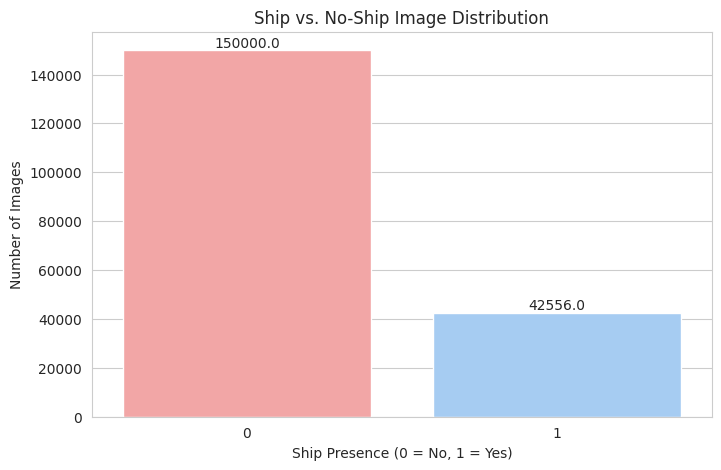

Images with NO ships: 150000
Images with at least ONE ship: 42556


In [9]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(x='HasShip', data=image_df, palette=['#FF9999', '#99CCFF'])
plt.title('Ship vs. No-Ship Image Distribution')
plt.xlabel('Ship Presence (0 = No, 1 = Yes)')
plt.ylabel('Number of Images')

# Add annotations
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

print(f"Images with NO ships: {(image_df['HasShip'] == 0).sum()}")
print(f"Images with at least ONE ship: {(image_df['HasShip'] == 1).sum()}")

**Insight:** We have a significant class imbalance. Over 70% of the images have no ships. This is why we must stratify our data split later.

### **Plot 2: Ship Count Distribution**

For the images that do have ships, how many do they typically have?

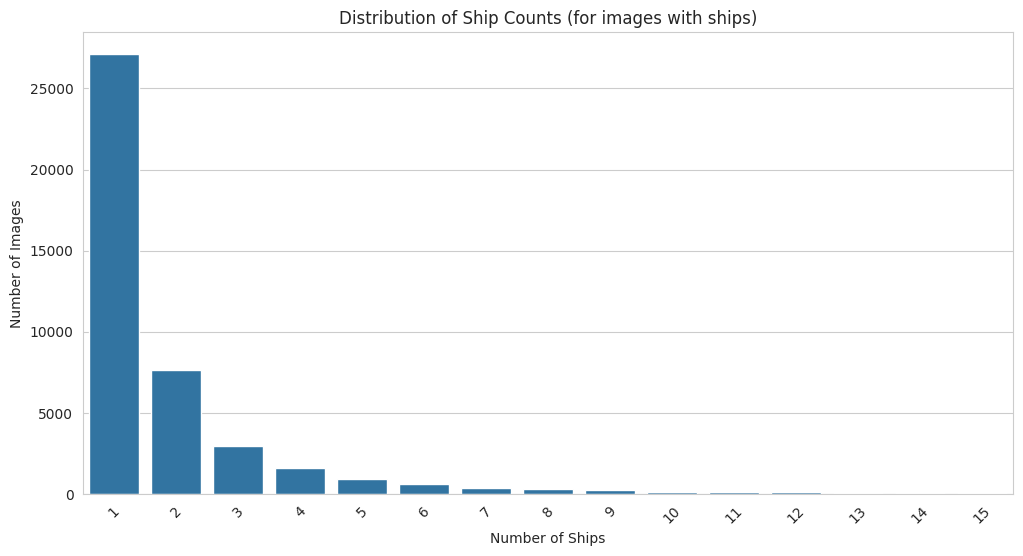

In [10]:
plt.figure(figsize=(12, 6))
# Filter for images with at least one ship
ship_counts = image_df[image_df['HasShip'] == 1]['ShipCount']
sns.countplot(x=ship_counts)
plt.title('Distribution of Ship Counts (for images with ships)')
plt.xlabel('Number of Ships')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

**Insight:** Most ship-containing images have only 1 or 2 ships, but there's a long tail with some images having 15 or more.

### **Visualize Images and Masks**

Let's write our helper functions to decode the Run-Length Encoding (RLE) and display an image with its masks overlaid.

In [11]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Need to transpose

In [12]:
def show_image_with_masks(image_id):
    """
    Loads an image and all its masks, then displays them.
    """
    img_path = os.path.join(TRAIN_DIR, image_id)
    try:
        img = imread(img_path)
    except FileNotFoundError:
        print(f"Error: Image {image_id} not found at {img_path}")
        return

    # Get the RleMasks list from our aggregated dataframe
    rle_masks = image_df[image_df['ImageId'] == image_id]['RleMasks'].values[0]
    
    # Decode all masks and combine them into one array
    all_masks = np.zeros((768, 768), dtype=np.uint8)
    if not rle_masks:
        print(f"Image {image_id} has no ships.")
    else:
        print(f"Image {image_id} has {len(rle_masks)} ship(s).")
        for rle in rle_masks:
            all_masks += rle_decode(rle)

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(img)
    if rle_masks: # Only overlay if masks exist
        # Use np.ma.masked_where to create a transparent overlay
        ax[1].imshow(np.ma.masked_where(all_masks == 0, all_masks), cmap='Reds', alpha=0.4)
    ax[1].set_title('Image with Masks')
    ax[1].axis('off')
    plt.show()

Now let's use our function to see some examples.

### **Example 1: An image with ships**

Image 9f2a72748.jpg has 2 ship(s).


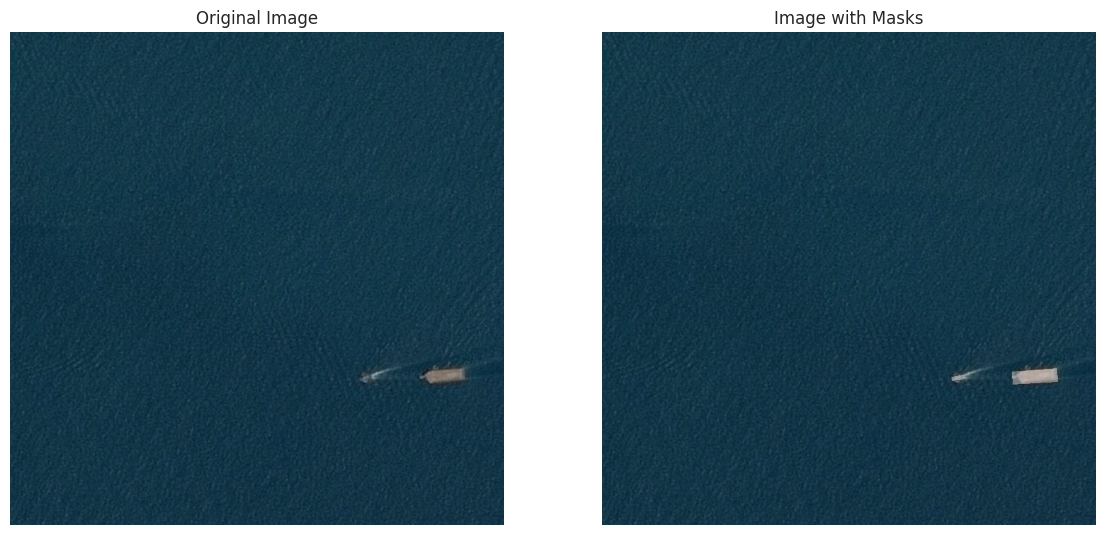

In [13]:
# Get a random sample from images that HAVE ships
ship_image_id = image_df[image_df['HasShip'] == 1].sample(1)['ImageId'].values[0]
show_image_with_masks(ship_image_id)

### **Example 2: An image without ships**

Image 3913e21bd.jpg has no ships.


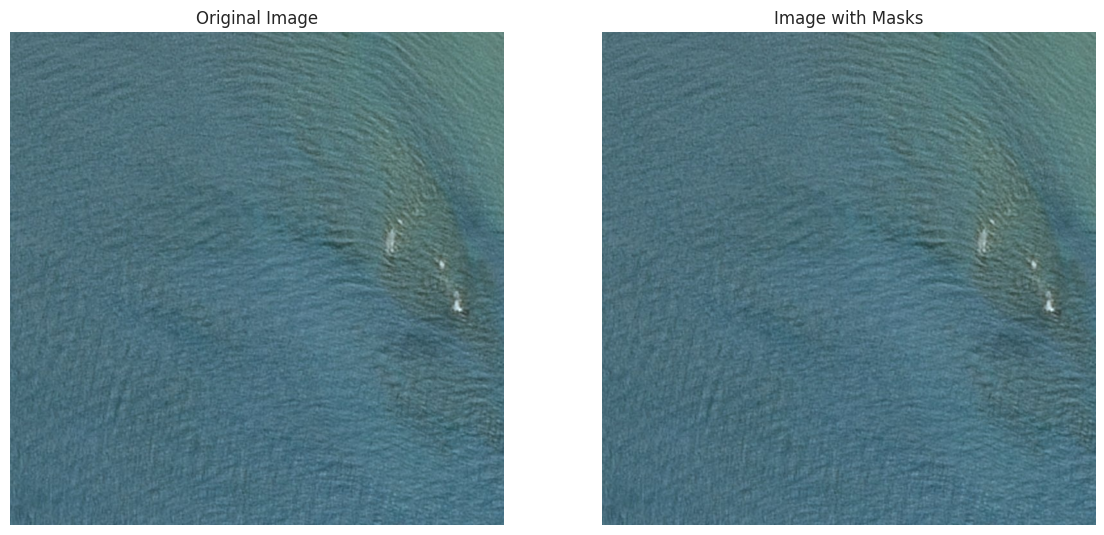

In [14]:
# Get a random sample from images that DO NOT have ships
no_ship_id = image_df[image_df['HasShip'] == 0].sample(1)['ImageId'].values[0]
show_image_with_masks(no_ship_id)

## **Data Splitting (Train, Validation, Test)**

This is the final step for our milestone. We need to split our `image_df` into three sets.

Important:

Stratification: We must stratify the split using our `HasShip` column to ensure all three sets have the same percentage of ship/no-ship images.

Sample Size: The full dataset (192,556 images) is huge. For development, we'll use a smaller, stratified sample (e.g., 40,000 images). You can comment this out to use the full dataset for final training.

In [15]:
# --- Option 1: Use a smaller, stratified sample ---
SAMPLE_SIZE = 40000 
if len(image_df) > SAMPLE_SIZE:
    working_df, _ = train_test_split(
        image_df, 
        train_size=SAMPLE_SIZE, 
        stratify=image_df['HasShip'],
        random_state=42
    )
    print(f"Using a stratified sample of {len(working_df)} images.")
else:
# --- Option 2: Use the full dataset ---
    working_df = image_df.copy()
    print(f"Using the full dataset of {len(working_df)} images.")

Using a stratified sample of 40000 images.


Now we perform a two-step split to get our 70% / 15% / 15% sets.

In [16]:
# First split: 70% train, 30% (val + test)
train_df, val_test_df = train_test_split(
    working_df,
    test_size=0.3,
    stratify=working_df['HasShip'],
    random_state=42
)

# Second split: Split the 30% into 15% validation and 15% test
val_df, test_df = train_test_split(
    val_test_df,
    test_size=0.5,
    stratify=val_test_df['HasShip'],
    random_state=42
)

## **Final Verification**

Let's print the results to check our work. The sizes should be correct, and the percentage of images with ships (HasShip mean) should be nearly identical across all three sets.

In [17]:
print("\n--- Data Split Complete ---")
print(f"Total samples: {len(working_df)}")
print(f"Training set:   {len(train_df)} images ({len(train_df)/len(working_df):.1%})")
print(f"Validation set: {len(val_df)} images ({len(val_df)/len(working_df):.1%})")
print(f"Test set:       {len(test_df)} images ({len(test_df)/len(working_df):.1%})")

print("\n--- Stratification Check (Percentage of images with ships) ---")
print(f"Training set:   {train_df['HasShip'].mean():.2%}")
print(f"Validation set: {val_df['HasShip'].mean():.2%}")
print(f"Test set:       {test_df['HasShip'].mean():.2%}")

print("\n--- Training Set Head ---")
print(train_df.head())


--- Data Split Complete ---
Total samples: 40000
Training set:   28000 images (70.0%)
Validation set: 6000 images (15.0%)
Test set:       6000 images (15.0%)

--- Stratification Check (Percentage of images with ships) ---
Training set:   22.10%
Validation set: 22.10%
Test set:       22.10%

--- Training Set Head ---
              ImageId                                           RleMasks  \
92943   7b85ca391.jpg                                                 []   
162778  d878052a0.jpg                                                 []   
5541    07704b4a9.jpg                                                 []   
63875   55104d108.jpg  [324632 1 325399 3 326165 6 326932 8 327699 9 ...   
154549  cd831c5bb.jpg                                                 []   

        ShipCount  HasShip  
92943           0        0  
162778          0        0  
5541            0        0  
63875           2        1  
154549          0        0  


In [18]:
train_df.to_csv(os.path.join(BASE_DIR, 'train_split.csv'), index=False)
val_df.to_csv(os.path.join(BASE_DIR, 'val_split.csv'), index=False)
test_df.to_csv(os.path.join(BASE_DIR, 'test_split.csv'), index=False)
print("\nSaved split DataFrames to CSVs in 'data' folder.")


Saved split DataFrames to CSVs in 'data' folder.
